# Applying Custom CNN + SEBlock Attention Module On MLRSNet Dataset

In [48]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [49]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [51]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [54]:
data_dir = "/kaggle/input/mlrs-net/images"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: basketball_court --> count: 2895
class: dense_residential_area --> count: 2783
class: wetland --> count: 2612
class: vegetable_greenhouse --> count: 2601
class: snowberg --> count: 2555
class: desert --> count: 2539
class: parkway --> count: 2537
class: golf_course --> count: 2515
class: harbor_port --> count: 2505
class: parking_lot --> count: 2502
class: meadow --> count: 2502
class: farmland --> count: 2501
class: forest --> count: 2501
class: commercial_area --> count: 2500
class: freeway --> count: 2500
class: transmission_tower --> count: 2500
class: shipping_yard --> count: 2500
class: overpass --> count: 2500
class: eroded_farmland --> count: 2500
class: river --> count: 2500
class: ground_track_field --> count: 2500
class: bridge --> count: 2500
class: storage_tank --> count: 2500
class: beach --> count: 2500
class: tennis_court --> count: 2500
class: railway --> count: 2500
class: mountain --> count: 2500
class: lake --> count: 2500
class: terrace --> count: 2500
class

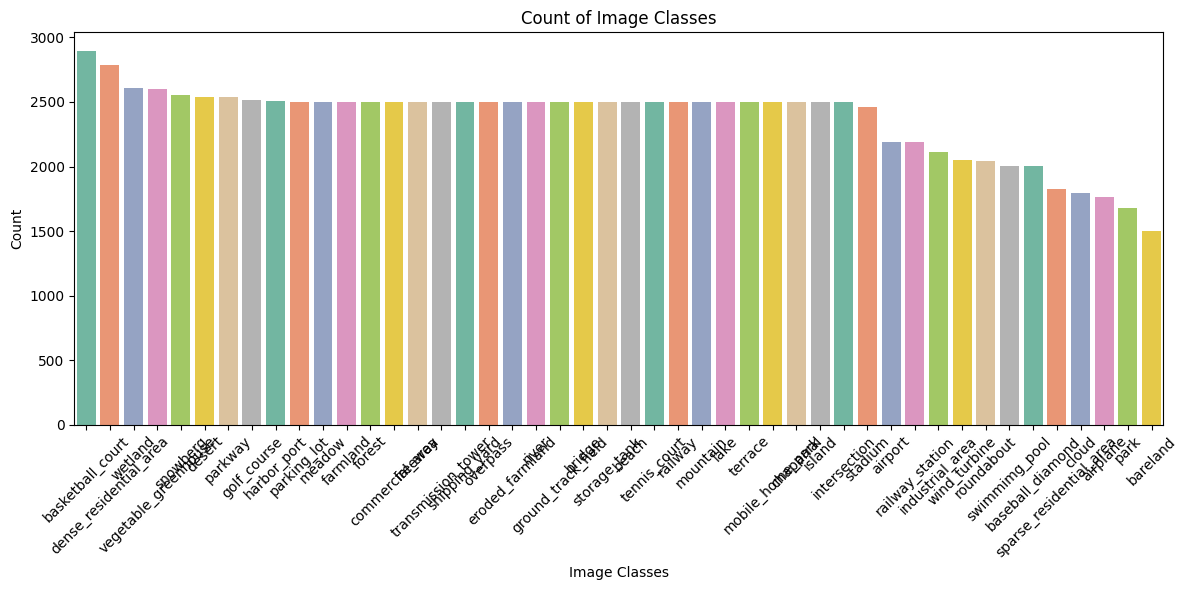

In [55]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

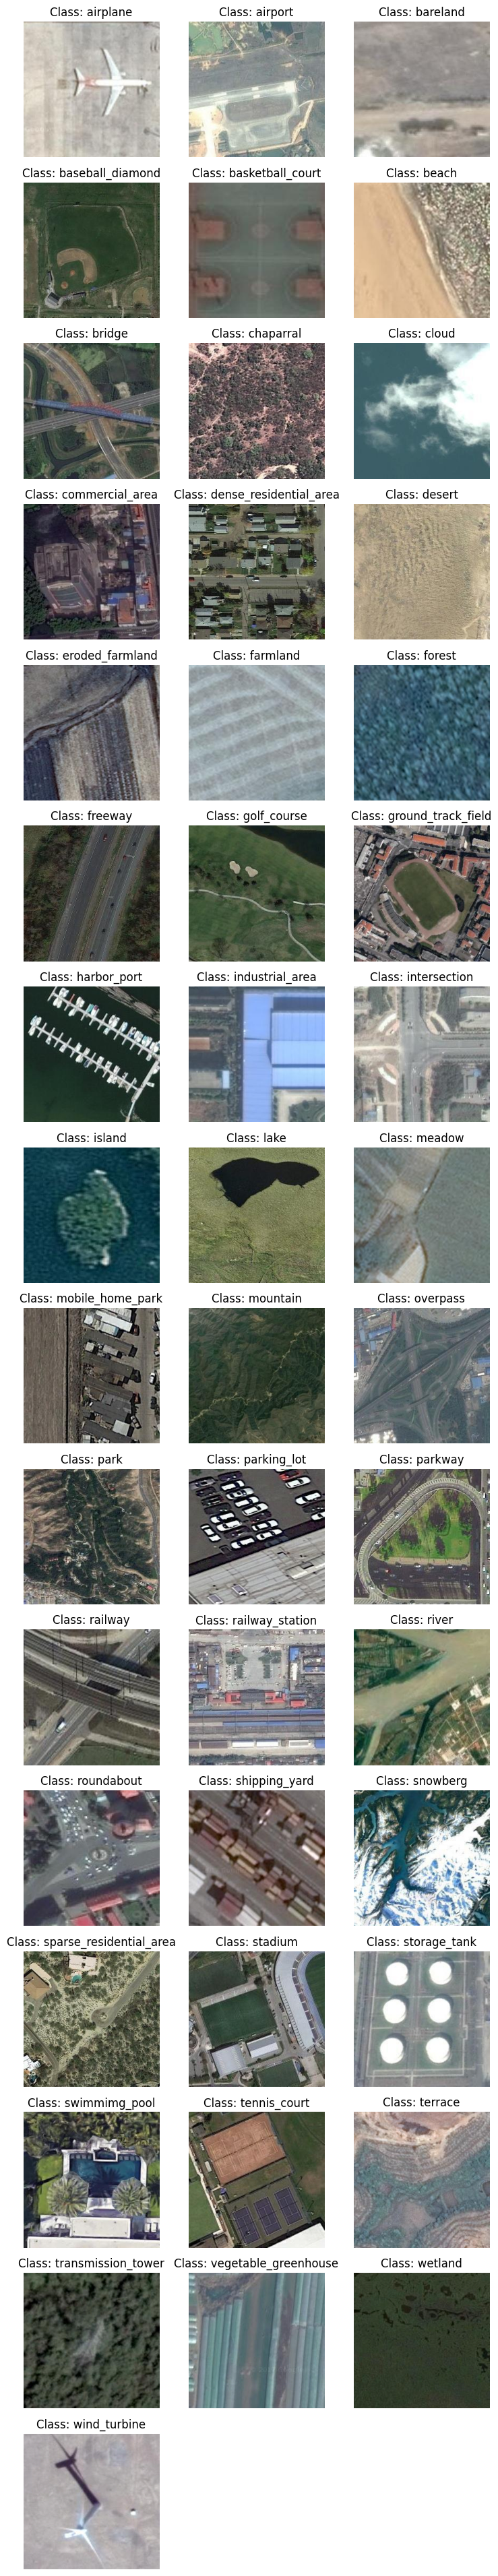

In [56]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [57]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [58]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  76412
Validation Data:  16374
Test Data:  16375
-------------------------------------------
Total amounts of data in the dataset:  109161


In [59]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                      Count
-----------------------  -------
basketball_court            2026
dense_residential_area      1948
wetland                     1828
vegetable_greenhouse        1821
snowberg                    1789
desert                      1777
parkway                     1776
golf_course                 1761
harbor_port                 1754
parking_lot                 1751
meadow                      1751
farmland                    1751
forest                      1751
overpass                    1750
tennis_court                1750
river                       1750
mobile_home_park            1750
storage_tank                1750
lake                        1750
commercial_area             1750
mountain                    1750
terrace                     1750
bridge                      1750
eroded_farmland             1750
freeway                     1750
transmission_tower          1750
railway                     1750
shipping_yard               1

label mapping

In [60]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'airplane': 0, 'airport': 1, 'bareland': 2, 'baseball_diamond': 3, 'basketball_court': 4, 'beach': 5, 'bridge': 6, 'chaparral': 7, 'cloud': 8, 'commercial_area': 9, 'dense_residential_area': 10, 'desert': 11, 'eroded_farmland': 12, 'farmland': 13, 'forest': 14, 'freeway': 15, 'golf_course': 16, 'ground_track_field': 17, 'harbor_port': 18, 'industrial_area': 19, 'intersection': 20, 'island': 21, 'lake': 22, 'meadow': 23, 'mobile_home_park': 24, 'mountain': 25, 'overpass': 26, 'park': 27, 'parking_lot': 28, 'parkway': 29, 'railway': 30, 'railway_station': 31, 'river': 32, 'roundabout': 33, 'shipping_yard': 34, 'snowberg': 35, 'sparse_residential_area': 36, 'stadium': 37, 'storage_tank': 38, 'swimmimg_pool': 39, 'tennis_court': 40, 'terrace': 41, 'transmission_tower': 42, 'vegetable_greenhouse': 43, 'wetland': 44, 'wind_turbine': 45}


### Device Variable

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [63]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [64]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [83]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path).convert('RGB')

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



train_batch = 256
val_batch = 8

def data_transfrom():
    size = 128
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [79]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)       # [B, C]
        y = self.fc(y).view(b, c, 1, 1)              # [B, C, 1, 1]
        return x * y.expand_as(x)

### Convolutional Neural Netwirk (G7CNN)

In [80]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 32 x 112 x 112
            
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 64 x 56 x 56
            

            # Block 3
            nn.Conv2d(64, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 84 x 28 x 28
            SEBlock(84),

            # Block 4
            nn.Conv2d(84, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 128 x 14 x 14
            SEBlock(128),
            
            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 256 x 7 x 7
            SEBlock(256),

        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 256 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 256
            nn.Linear(256, 256),                 # → 256
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x)    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [84]:
total_class = 46
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)
model.classifier[-1] = nn.Linear(256, total_class)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

### Training

In [85]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 299/299 [01:52<00:00,  2.66it/s, acc=0.305, loss=2.72]

Training Loss: 2.723 Acc: 0.305


Validation Loss: 1.815 Acc: 0.494
✅ Best model saved at epoch 1 with validation accuracy: 0.494


Epoch 2/150: 100%|██████████| 299/299 [01:50<00:00,  2.72it/s, acc=0.538, loss=1.65]


Training Loss: 1.647 Acc: 0.538
Validation Loss: 1.216 Acc: 0.650
✅ Best model saved at epoch 2 with validation accuracy: 0.650


Epoch 3/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.632, loss=1.29]


Training Loss: 1.291 Acc: 0.632
Validation Loss: 1.015 Acc: 0.706
✅ Best model saved at epoch 3 with validation accuracy: 0.706


Epoch 4/150: 100%|██████████| 299/299 [01:48<00:00,  2.74it/s, acc=0.685, loss=1.1] 


Training Loss: 1.097 Acc: 0.685
Validation Loss: 0.953 Acc: 0.720
✅ Best model saved at epoch 4 with validation accuracy: 0.720


Epoch 5/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.723, loss=0.956]


Training Loss: 0.956 Acc: 0.723
Validation Loss: 0.795 Acc: 0.770
✅ Best model saved at epoch 5 with validation accuracy: 0.770


Epoch 6/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.749, loss=0.861]


Training Loss: 0.861 Acc: 0.749
Validation Loss: 0.733 Acc: 0.782
✅ Best model saved at epoch 6 with validation accuracy: 0.782


Epoch 7/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.769, loss=0.784]


Training Loss: 0.784 Acc: 0.769
Validation Loss: 0.699 Acc: 0.792
✅ Best model saved at epoch 7 with validation accuracy: 0.792


Epoch 8/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.788, loss=0.719]


Training Loss: 0.719 Acc: 0.788
Validation Loss: 0.633 Acc: 0.809
✅ Best model saved at epoch 8 with validation accuracy: 0.809


Epoch 9/150: 100%|██████████| 299/299 [01:48<00:00,  2.76it/s, acc=0.802, loss=0.669]


Training Loss: 0.669 Acc: 0.802
Validation Loss: 0.563 Acc: 0.830
✅ Best model saved at epoch 9 with validation accuracy: 0.830


Epoch 10/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.814, loss=0.625]


Training Loss: 0.625 Acc: 0.814
Validation Loss: 0.601 Acc: 0.820


Epoch 11/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.825, loss=0.585]


Training Loss: 0.585 Acc: 0.825
Validation Loss: 0.502 Acc: 0.846
✅ Best model saved at epoch 11 with validation accuracy: 0.846


Epoch 12/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.834, loss=0.555]


Training Loss: 0.555 Acc: 0.834
Validation Loss: 0.588 Acc: 0.822


Epoch 13/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.843, loss=0.525]


Training Loss: 0.525 Acc: 0.843
Validation Loss: 0.498 Acc: 0.851
✅ Best model saved at epoch 13 with validation accuracy: 0.851


Epoch 14/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.848, loss=0.504]


Training Loss: 0.504 Acc: 0.848
Validation Loss: 0.450 Acc: 0.862
✅ Best model saved at epoch 14 with validation accuracy: 0.862


Epoch 15/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.859, loss=0.469]


Training Loss: 0.469 Acc: 0.859
Validation Loss: 0.464 Acc: 0.858


Epoch 16/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.865, loss=0.447]


Training Loss: 0.447 Acc: 0.865
Validation Loss: 0.406 Acc: 0.875
✅ Best model saved at epoch 16 with validation accuracy: 0.875


Epoch 17/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.87, loss=0.431] 


Training Loss: 0.431 Acc: 0.870
Validation Loss: 0.466 Acc: 0.860


Epoch 18/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.872, loss=0.418]


Training Loss: 0.418 Acc: 0.872
Validation Loss: 0.376 Acc: 0.887
✅ Best model saved at epoch 18 with validation accuracy: 0.887


Epoch 19/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.877, loss=0.399]


Training Loss: 0.399 Acc: 0.877
Validation Loss: 0.422 Acc: 0.873


Epoch 20/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.881, loss=0.384]


Training Loss: 0.384 Acc: 0.881
Validation Loss: 0.393 Acc: 0.879


Epoch 21/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.885, loss=0.369]


Training Loss: 0.369 Acc: 0.885
Validation Loss: 0.421 Acc: 0.876


Epoch 22/150: 100%|██████████| 299/299 [01:50<00:00,  2.72it/s, acc=0.89, loss=0.352] 


Training Loss: 0.352 Acc: 0.890
Validation Loss: 0.375 Acc: 0.885


Epoch 23/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.895, loss=0.343]


Training Loss: 0.343 Acc: 0.895
Validation Loss: 0.380 Acc: 0.884


Epoch 24/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.896, loss=0.336]


Training Loss: 0.336 Acc: 0.896
Validation Loss: 0.356 Acc: 0.890
✅ Best model saved at epoch 24 with validation accuracy: 0.890


Epoch 25/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.9, loss=0.322]  


Training Loss: 0.322 Acc: 0.900
Validation Loss: 0.350 Acc: 0.891
✅ Best model saved at epoch 25 with validation accuracy: 0.891


Epoch 26/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.903, loss=0.31] 


Training Loss: 0.310 Acc: 0.903
Validation Loss: 0.355 Acc: 0.894
✅ Best model saved at epoch 26 with validation accuracy: 0.894


Epoch 27/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.906, loss=0.301]


Training Loss: 0.301 Acc: 0.906
Validation Loss: 0.340 Acc: 0.898
✅ Best model saved at epoch 27 with validation accuracy: 0.898


Epoch 28/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.908, loss=0.296]


Training Loss: 0.296 Acc: 0.908
Validation Loss: 0.325 Acc: 0.901
✅ Best model saved at epoch 28 with validation accuracy: 0.901


Epoch 29/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.911, loss=0.285]


Training Loss: 0.285 Acc: 0.911
Validation Loss: 0.321 Acc: 0.904
✅ Best model saved at epoch 29 with validation accuracy: 0.904


Epoch 30/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.913, loss=0.277]


Training Loss: 0.277 Acc: 0.913
Validation Loss: 0.311 Acc: 0.906
✅ Best model saved at epoch 30 with validation accuracy: 0.906


Epoch 31/150: 100%|██████████| 299/299 [01:53<00:00,  2.64it/s, acc=0.915, loss=0.267]


Training Loss: 0.267 Acc: 0.915
Validation Loss: 0.388 Acc: 0.886


Epoch 32/150: 100%|██████████| 299/299 [01:51<00:00,  2.67it/s, acc=0.916, loss=0.265]


Training Loss: 0.265 Acc: 0.916
Validation Loss: 0.304 Acc: 0.910
✅ Best model saved at epoch 32 with validation accuracy: 0.910


Epoch 33/150: 100%|██████████| 299/299 [01:53<00:00,  2.64it/s, acc=0.919, loss=0.254]


Training Loss: 0.254 Acc: 0.919
Validation Loss: 0.318 Acc: 0.902


Epoch 34/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.92, loss=0.251] 


Training Loss: 0.251 Acc: 0.920
Validation Loss: 0.305 Acc: 0.906


Epoch 35/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.922, loss=0.243]


Training Loss: 0.243 Acc: 0.922
Validation Loss: 0.312 Acc: 0.906


Epoch 36/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.925, loss=0.235]


Training Loss: 0.235 Acc: 0.925
Validation Loss: 0.288 Acc: 0.914
✅ Best model saved at epoch 36 with validation accuracy: 0.914


Epoch 37/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.927, loss=0.23] 


Training Loss: 0.230 Acc: 0.927
Validation Loss: 0.292 Acc: 0.913


Epoch 38/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.929, loss=0.221]


Training Loss: 0.221 Acc: 0.929
Validation Loss: 0.287 Acc: 0.914


Epoch 39/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.93, loss=0.22]  


Training Loss: 0.220 Acc: 0.930
Validation Loss: 0.289 Acc: 0.915
✅ Best model saved at epoch 39 with validation accuracy: 0.915


Epoch 40/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.931, loss=0.213]


Training Loss: 0.213 Acc: 0.931
Validation Loss: 0.292 Acc: 0.913


Epoch 41/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.932, loss=0.21] 


Training Loss: 0.210 Acc: 0.932
Validation Loss: 0.298 Acc: 0.912


Epoch 42/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.935, loss=0.204]


Training Loss: 0.204 Acc: 0.935
Validation Loss: 0.323 Acc: 0.908


Epoch 43/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.935, loss=0.201]


Training Loss: 0.201 Acc: 0.935
Validation Loss: 0.314 Acc: 0.908


Epoch 44/150: 100%|██████████| 299/299 [01:48<00:00,  2.76it/s, acc=0.937, loss=0.195]


Training Loss: 0.195 Acc: 0.937
Validation Loss: 0.273 Acc: 0.919
✅ Best model saved at epoch 44 with validation accuracy: 0.919


Epoch 45/150: 100%|██████████| 299/299 [01:48<00:00,  2.76it/s, acc=0.937, loss=0.193]


Training Loss: 0.193 Acc: 0.937
Validation Loss: 0.305 Acc: 0.912


Epoch 46/150: 100%|██████████| 299/299 [01:50<00:00,  2.72it/s, acc=0.938, loss=0.188]


Training Loss: 0.188 Acc: 0.938
Validation Loss: 0.268 Acc: 0.921
✅ Best model saved at epoch 46 with validation accuracy: 0.921


Epoch 47/150: 100%|██████████| 299/299 [01:51<00:00,  2.67it/s, acc=0.941, loss=0.183]


Training Loss: 0.183 Acc: 0.941
Validation Loss: 0.289 Acc: 0.915


Epoch 48/150: 100%|██████████| 299/299 [01:48<00:00,  2.76it/s, acc=0.941, loss=0.179]


Training Loss: 0.179 Acc: 0.941
Validation Loss: 0.292 Acc: 0.918


Epoch 49/150: 100%|██████████| 299/299 [01:48<00:00,  2.74it/s, acc=0.942, loss=0.177]


Training Loss: 0.177 Acc: 0.942
Validation Loss: 0.248 Acc: 0.926
✅ Best model saved at epoch 49 with validation accuracy: 0.926


Epoch 50/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.942, loss=0.176]


Training Loss: 0.176 Acc: 0.942
Validation Loss: 0.268 Acc: 0.922


Epoch 51/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.946, loss=0.165]


Training Loss: 0.165 Acc: 0.946
Validation Loss: 0.256 Acc: 0.925


Epoch 52/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.945, loss=0.167]


Training Loss: 0.167 Acc: 0.945
Validation Loss: 0.277 Acc: 0.918


Epoch 53/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.945, loss=0.162]


Training Loss: 0.162 Acc: 0.945
Validation Loss: 0.262 Acc: 0.923


Epoch 54/150: 100%|██████████| 299/299 [01:50<00:00,  2.72it/s, acc=0.949, loss=0.156]


Training Loss: 0.156 Acc: 0.949
Validation Loss: 0.249 Acc: 0.927
✅ Best model saved at epoch 54 with validation accuracy: 0.927


Epoch 55/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.95, loss=0.154] 


Training Loss: 0.154 Acc: 0.950
Validation Loss: 0.274 Acc: 0.921


Epoch 56/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.948, loss=0.156]


Training Loss: 0.156 Acc: 0.948
Validation Loss: 0.291 Acc: 0.917


Epoch 57/150: 100%|██████████| 299/299 [01:48<00:00,  2.74it/s, acc=0.949, loss=0.154]


Training Loss: 0.154 Acc: 0.949
Validation Loss: 0.279 Acc: 0.920


Epoch 58/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.952, loss=0.145]


Training Loss: 0.145 Acc: 0.952
Validation Loss: 0.269 Acc: 0.922


Epoch 59/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.953, loss=0.144]


Training Loss: 0.144 Acc: 0.953
Validation Loss: 0.261 Acc: 0.926


Epoch 60/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.953, loss=0.143]


Training Loss: 0.143 Acc: 0.953
Validation Loss: 0.277 Acc: 0.923


Epoch 61/150: 100%|██████████| 299/299 [01:53<00:00,  2.63it/s, acc=0.953, loss=0.14] 


Training Loss: 0.140 Acc: 0.953
Validation Loss: 0.266 Acc: 0.926


Epoch 62/150: 100%|██████████| 299/299 [01:52<00:00,  2.65it/s, acc=0.955, loss=0.137]


Training Loss: 0.137 Acc: 0.955
Validation Loss: 0.261 Acc: 0.928
✅ Best model saved at epoch 62 with validation accuracy: 0.928


Epoch 63/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.957, loss=0.133]


Training Loss: 0.133 Acc: 0.957
Validation Loss: 0.247 Acc: 0.930
✅ Best model saved at epoch 63 with validation accuracy: 0.930


Epoch 64/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.957, loss=0.133]


Training Loss: 0.133 Acc: 0.957
Validation Loss: 0.279 Acc: 0.923


Epoch 65/150: 100%|██████████| 299/299 [01:50<00:00,  2.72it/s, acc=0.958, loss=0.129]


Training Loss: 0.129 Acc: 0.958
Validation Loss: 0.256 Acc: 0.929


Epoch 66/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.959, loss=0.128]


Training Loss: 0.128 Acc: 0.959
Validation Loss: 0.292 Acc: 0.922


Epoch 67/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.958, loss=0.126]


Training Loss: 0.126 Acc: 0.958
Validation Loss: 0.248 Acc: 0.933
✅ Best model saved at epoch 67 with validation accuracy: 0.933


Epoch 68/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.959, loss=0.121]


Training Loss: 0.121 Acc: 0.959
Validation Loss: 0.281 Acc: 0.923


Epoch 69/150: 100%|██████████| 299/299 [01:48<00:00,  2.74it/s, acc=0.96, loss=0.119] 


Training Loss: 0.119 Acc: 0.960
Validation Loss: 0.244 Acc: 0.933


Epoch 70/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.96, loss=0.122] 


Training Loss: 0.122 Acc: 0.960
Validation Loss: 0.286 Acc: 0.924


Epoch 71/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.962, loss=0.114]


Training Loss: 0.114 Acc: 0.962
Validation Loss: 0.261 Acc: 0.928


Epoch 72/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.962, loss=0.117]


Training Loss: 0.117 Acc: 0.962
Validation Loss: 0.274 Acc: 0.925


Epoch 73/150: 100%|██████████| 299/299 [01:50<00:00,  2.72it/s, acc=0.962, loss=0.112]


Training Loss: 0.112 Acc: 0.962
Validation Loss: 0.270 Acc: 0.928


Epoch 74/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.962, loss=0.115]


Training Loss: 0.115 Acc: 0.962
Validation Loss: 0.253 Acc: 0.931


Epoch 75/150: 100%|██████████| 299/299 [01:48<00:00,  2.76it/s, acc=0.962, loss=0.111]


Training Loss: 0.111 Acc: 0.962
Validation Loss: 0.268 Acc: 0.927


Epoch 76/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.965, loss=0.105]


Training Loss: 0.105 Acc: 0.965
Validation Loss: 0.271 Acc: 0.927


Epoch 77/150: 100%|██████████| 299/299 [01:48<00:00,  2.74it/s, acc=0.964, loss=0.108]


Training Loss: 0.108 Acc: 0.964
Validation Loss: 0.250 Acc: 0.934
✅ Best model saved at epoch 77 with validation accuracy: 0.934


Epoch 78/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.965, loss=0.105] 


Training Loss: 0.105 Acc: 0.965
Validation Loss: 0.243 Acc: 0.937
✅ Best model saved at epoch 78 with validation accuracy: 0.937


Epoch 79/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.966, loss=0.101] 


Training Loss: 0.101 Acc: 0.966
Validation Loss: 0.234 Acc: 0.936


Epoch 80/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.966, loss=0.101] 


Training Loss: 0.101 Acc: 0.966
Validation Loss: 0.267 Acc: 0.929


Epoch 81/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.965, loss=0.101] 


Training Loss: 0.101 Acc: 0.965
Validation Loss: 0.238 Acc: 0.937
✅ Best model saved at epoch 81 with validation accuracy: 0.937


Epoch 82/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.967, loss=0.0984]


Training Loss: 0.098 Acc: 0.967
Validation Loss: 0.263 Acc: 0.933


Epoch 83/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.968, loss=0.0969]


Training Loss: 0.097 Acc: 0.968
Validation Loss: 0.275 Acc: 0.929


Epoch 84/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.968, loss=0.0939]


Training Loss: 0.094 Acc: 0.968
Validation Loss: 0.233 Acc: 0.936


Epoch 85/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.968, loss=0.0942]


Training Loss: 0.094 Acc: 0.968
Validation Loss: 0.296 Acc: 0.926


Epoch 86/150: 100%|██████████| 299/299 [01:48<00:00,  2.74it/s, acc=0.968, loss=0.0944]


Training Loss: 0.094 Acc: 0.968
Validation Loss: 0.237 Acc: 0.938
✅ Best model saved at epoch 86 with validation accuracy: 0.938


Epoch 87/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.969, loss=0.089] 


Training Loss: 0.089 Acc: 0.969
Validation Loss: 0.258 Acc: 0.935


Epoch 88/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.969, loss=0.0918]


Training Loss: 0.092 Acc: 0.969
Validation Loss: 0.233 Acc: 0.938
✅ Best model saved at epoch 88 with validation accuracy: 0.938


Epoch 89/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.971, loss=0.0872]


Training Loss: 0.087 Acc: 0.971
Validation Loss: 0.266 Acc: 0.931


Epoch 90/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.97, loss=0.0866] 


Training Loss: 0.087 Acc: 0.970
Validation Loss: 0.267 Acc: 0.931


Epoch 91/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.971, loss=0.0866]


Training Loss: 0.087 Acc: 0.971
Validation Loss: 0.246 Acc: 0.937


Epoch 92/150: 100%|██████████| 299/299 [01:51<00:00,  2.68it/s, acc=0.971, loss=0.0866]


Training Loss: 0.087 Acc: 0.971
Validation Loss: 0.246 Acc: 0.935


Epoch 93/150: 100%|██████████| 299/299 [01:53<00:00,  2.63it/s, acc=0.971, loss=0.0856]


Training Loss: 0.086 Acc: 0.971
Validation Loss: 0.290 Acc: 0.929


Epoch 94/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.972, loss=0.0829]


Training Loss: 0.083 Acc: 0.972
Validation Loss: 0.243 Acc: 0.938
✅ Best model saved at epoch 94 with validation accuracy: 0.938


Epoch 95/150: 100%|██████████| 299/299 [01:51<00:00,  2.69it/s, acc=0.972, loss=0.0823]


Training Loss: 0.082 Acc: 0.972
Validation Loss: 0.272 Acc: 0.931


Epoch 96/150: 100%|██████████| 299/299 [01:50<00:00,  2.72it/s, acc=0.972, loss=0.0817]


Training Loss: 0.082 Acc: 0.972
Validation Loss: 0.272 Acc: 0.930


Epoch 97/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.973, loss=0.0799]


Training Loss: 0.080 Acc: 0.973
Validation Loss: 0.252 Acc: 0.936


Epoch 98/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.974, loss=0.0786]


Training Loss: 0.079 Acc: 0.974
Validation Loss: 0.244 Acc: 0.939
✅ Best model saved at epoch 98 with validation accuracy: 0.939


Epoch 99/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.975, loss=0.0746]


Training Loss: 0.075 Acc: 0.975
Validation Loss: 0.254 Acc: 0.937


Epoch 100/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.972, loss=0.0808]


Training Loss: 0.081 Acc: 0.972
Validation Loss: 0.271 Acc: 0.935


Epoch 101/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.975, loss=0.0741]


Training Loss: 0.074 Acc: 0.975
Validation Loss: 0.263 Acc: 0.936


Epoch 102/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.975, loss=0.0746]


Training Loss: 0.075 Acc: 0.975
Validation Loss: 0.281 Acc: 0.933


Epoch 103/150: 100%|██████████| 299/299 [01:51<00:00,  2.67it/s, acc=0.974, loss=0.0739]


Training Loss: 0.074 Acc: 0.974
Validation Loss: 0.306 Acc: 0.925


Epoch 104/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.975, loss=0.073] 


Training Loss: 0.073 Acc: 0.975
Validation Loss: 0.263 Acc: 0.936


Epoch 105/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.976, loss=0.0714]


Training Loss: 0.071 Acc: 0.976
Validation Loss: 0.271 Acc: 0.935


Epoch 106/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.976, loss=0.0723]


Training Loss: 0.072 Acc: 0.976
Validation Loss: 0.258 Acc: 0.935


Epoch 107/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.975, loss=0.0729]


Training Loss: 0.073 Acc: 0.975
Validation Loss: 0.253 Acc: 0.937


Epoch 108/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.977, loss=0.0688]


Training Loss: 0.069 Acc: 0.977
Validation Loss: 0.301 Acc: 0.928


Epoch 109/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.977, loss=0.0688]


Training Loss: 0.069 Acc: 0.977
Validation Loss: 0.271 Acc: 0.934


Epoch 110/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.977, loss=0.0682]


Training Loss: 0.068 Acc: 0.977
Validation Loss: 0.254 Acc: 0.937


Epoch 111/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.978, loss=0.0666]


Training Loss: 0.067 Acc: 0.978
Validation Loss: 0.248 Acc: 0.939


Epoch 112/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.978, loss=0.0648]


Training Loss: 0.065 Acc: 0.978
Validation Loss: 0.269 Acc: 0.935


Epoch 113/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.977, loss=0.0671]


Training Loss: 0.067 Acc: 0.977
Validation Loss: 0.252 Acc: 0.939


Epoch 114/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.978, loss=0.0637]


Training Loss: 0.064 Acc: 0.978
Validation Loss: 0.259 Acc: 0.940
✅ Best model saved at epoch 114 with validation accuracy: 0.940


Epoch 115/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.977, loss=0.0672]


Training Loss: 0.067 Acc: 0.977
Validation Loss: 0.241 Acc: 0.941
✅ Best model saved at epoch 115 with validation accuracy: 0.941


Epoch 116/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.978, loss=0.0663]


Training Loss: 0.066 Acc: 0.978
Validation Loss: 0.260 Acc: 0.939


Epoch 117/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.978, loss=0.0632]


Training Loss: 0.063 Acc: 0.978
Validation Loss: 0.249 Acc: 0.941


Epoch 118/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.978, loss=0.0646]


Training Loss: 0.065 Acc: 0.978
Validation Loss: 0.249 Acc: 0.940


Epoch 119/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.979, loss=0.0605]


Training Loss: 0.061 Acc: 0.979
Validation Loss: 0.246 Acc: 0.941


Epoch 120/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.979, loss=0.0608]


Training Loss: 0.061 Acc: 0.979
Validation Loss: 0.274 Acc: 0.937


Epoch 121/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.979, loss=0.0592]


Training Loss: 0.059 Acc: 0.979
Validation Loss: 0.256 Acc: 0.939


Epoch 122/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.979, loss=0.0609]


Training Loss: 0.061 Acc: 0.979
Validation Loss: 0.292 Acc: 0.933


Epoch 123/150: 100%|██████████| 299/299 [01:48<00:00,  2.74it/s, acc=0.98, loss=0.0581] 


Training Loss: 0.058 Acc: 0.980
Validation Loss: 0.284 Acc: 0.933


Epoch 124/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.981, loss=0.057] 


Training Loss: 0.057 Acc: 0.981
Validation Loss: 0.277 Acc: 0.938


Epoch 125/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.979, loss=0.062] 


Training Loss: 0.062 Acc: 0.979
Validation Loss: 0.242 Acc: 0.944
✅ Best model saved at epoch 125 with validation accuracy: 0.944


Epoch 126/150: 100%|██████████| 299/299 [01:50<00:00,  2.70it/s, acc=0.98, loss=0.0577] 


Training Loss: 0.058 Acc: 0.980
Validation Loss: 0.257 Acc: 0.940


Epoch 127/150: 100%|██████████| 299/299 [01:50<00:00,  2.71it/s, acc=0.982, loss=0.0532]


Training Loss: 0.053 Acc: 0.982
Validation Loss: 0.271 Acc: 0.939


Epoch 128/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.98, loss=0.0578] 


Training Loss: 0.058 Acc: 0.980
Validation Loss: 0.247 Acc: 0.940


Epoch 129/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.981, loss=0.058] 


Training Loss: 0.058 Acc: 0.981
Validation Loss: 0.260 Acc: 0.941


Epoch 130/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.982, loss=0.0545]


Training Loss: 0.054 Acc: 0.982
Validation Loss: 0.251 Acc: 0.940


Epoch 131/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.982, loss=0.0548]


Training Loss: 0.055 Acc: 0.982
Validation Loss: 0.267 Acc: 0.938


Epoch 132/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.98, loss=0.058] 


Training Loss: 0.058 Acc: 0.980
Validation Loss: 0.245 Acc: 0.945
✅ Best model saved at epoch 132 with validation accuracy: 0.945


Epoch 133/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.982, loss=0.0543]


Training Loss: 0.054 Acc: 0.982
Validation Loss: 0.254 Acc: 0.941


Epoch 134/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.983, loss=0.0503]


Training Loss: 0.050 Acc: 0.983
Validation Loss: 0.240 Acc: 0.942


Epoch 135/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.982, loss=0.0522]


Training Loss: 0.052 Acc: 0.982
Validation Loss: 0.293 Acc: 0.936


Epoch 136/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.982, loss=0.0535]


Training Loss: 0.054 Acc: 0.982
Validation Loss: 0.241 Acc: 0.945
✅ Best model saved at epoch 136 with validation accuracy: 0.945


Epoch 137/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.983, loss=0.0489]


Training Loss: 0.049 Acc: 0.983
Validation Loss: 0.275 Acc: 0.939


Epoch 138/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.981, loss=0.0549]


Training Loss: 0.055 Acc: 0.981
Validation Loss: 0.247 Acc: 0.942


Epoch 139/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.983, loss=0.0508]


Training Loss: 0.051 Acc: 0.983
Validation Loss: 0.250 Acc: 0.943


Epoch 140/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.982, loss=0.0534]


Training Loss: 0.053 Acc: 0.982
Validation Loss: 0.273 Acc: 0.937


Epoch 141/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.983, loss=0.0504]


Training Loss: 0.050 Acc: 0.983
Validation Loss: 0.312 Acc: 0.932


Epoch 142/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.983, loss=0.0506]


Training Loss: 0.051 Acc: 0.983
Validation Loss: 0.269 Acc: 0.940


Epoch 143/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.983, loss=0.0502]


Training Loss: 0.050 Acc: 0.983
Validation Loss: 0.265 Acc: 0.939


Epoch 144/150: 100%|██████████| 299/299 [01:49<00:00,  2.72it/s, acc=0.984, loss=0.0481]


Training Loss: 0.048 Acc: 0.984
Validation Loss: 0.259 Acc: 0.941


Epoch 145/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.983, loss=0.0487]


Training Loss: 0.049 Acc: 0.983
Validation Loss: 0.251 Acc: 0.943


Epoch 146/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.982, loss=0.0504]


Training Loss: 0.050 Acc: 0.982
Validation Loss: 0.264 Acc: 0.940


Epoch 147/150: 100%|██████████| 299/299 [01:49<00:00,  2.74it/s, acc=0.984, loss=0.0473]


Training Loss: 0.047 Acc: 0.984
Validation Loss: 0.252 Acc: 0.942


Epoch 148/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.984, loss=0.0472]


Training Loss: 0.047 Acc: 0.984
Validation Loss: 0.256 Acc: 0.943


Epoch 149/150: 100%|██████████| 299/299 [01:48<00:00,  2.75it/s, acc=0.984, loss=0.0465]


Training Loss: 0.046 Acc: 0.984
Validation Loss: 0.270 Acc: 0.940


Epoch 150/150: 100%|██████████| 299/299 [01:49<00:00,  2.73it/s, acc=0.984, loss=0.0476]


Training Loss: 0.048 Acc: 0.984
Validation Loss: 0.263 Acc: 0.941
Training Time: 18815.59 seconds ---> 313.59 minutes


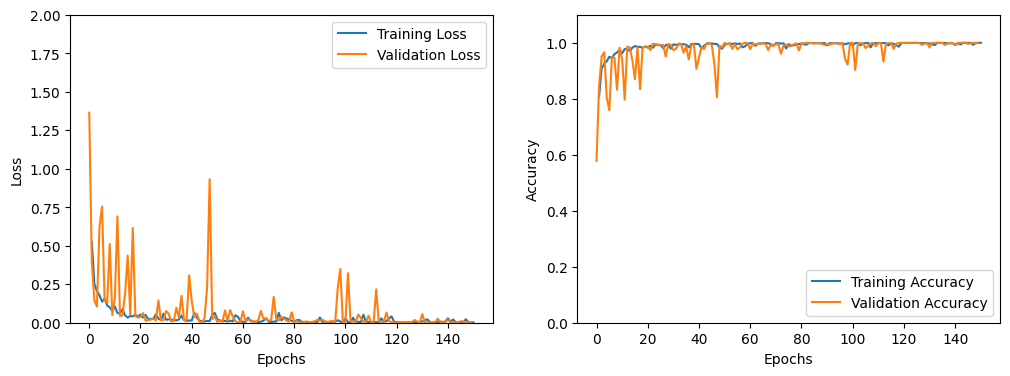

In [41]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [42]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 83) - Validation Loss: 0.001, Validation Accuracy: 1.000


In [43]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 1.000
Test Time: 10.17 seconds ---> 0.17 minutes


### Class Accuracy

In [44]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00       750

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

Class 0 Accuracy: 1.000
Class 1 Accuracy: 1.000
Class 2 Accuracy: 0.999


### Confusion Matrix

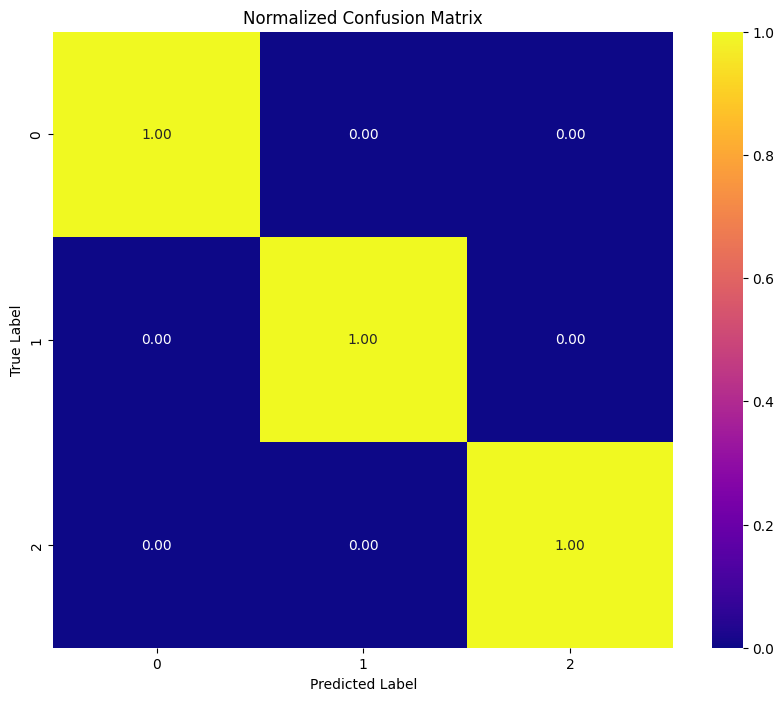

In [45]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

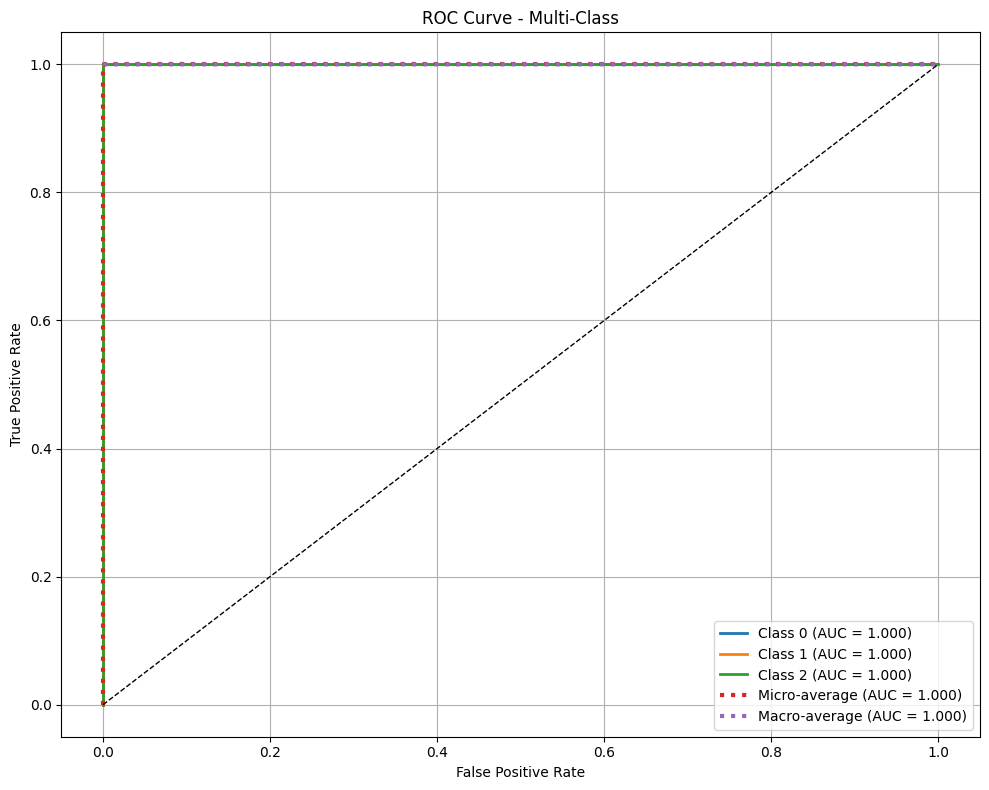

In [46]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()